## Step 1 - Launch PyMAPDL and Importing Libraries

In [20]:
mapdl.exit()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

from ansys.mapdl.core import launch_mapdl
exec_loc = 'C:/Program Files/ANSYS Inc/ANSYS Student/v222/ANSYS/bin/winx64/ANSYS222.exe'
# exec_loc = 'D:/Program Files/ANSYS Inc/v222/ANSYS/bin/winx64/ANSYS222.exe'

# start mapdl
mapdl = launch_mapdl(exec_loc)
print(mapdl)

FileNotFoundError: Invalid MAPDL executable at "C:/Program Files/ANSYS Inc/ANSYS Student/v222/ANSYS/bin/winx64/ANSYS222.exe"
Enter one manually using exec_file=

## Step 2 - test subroutine on Fiber Elastic Energy

In [2]:
# these two classes does unit converts
class Material:
    """
    elastic modulus (kPa), 
    poisson ratio 
    work of adhesion (mJ/m^2)
    """
    def __init__(self, E_modulus = 500, nu=0.4, w_ad = 20):
        self.E_modulus = E_modulus*1e-3  # elasticu modulus: kPa -> uN/um^2
        self.nu = nu                     # poisson ratio: dimensionless
        self.w_ad = w_ad *1e-3           # work of adhesion: mJ/m^2 -> uN/um  

class Geometry:
    """
    unit (um)
    """    
    def __init__(self, height = 100, diameter=50, curve=[]):
        self.height = height        # fiber height: um
        self.diameter = diameter    # fiber average diameter: um
        self.curve = curve          # curved side profile, either None (straight edge) or 1D array of radius

# MAPDL codes for getting total elastic strain energy of one fiber under partial detachment
def get_Ue(mat, geo, c_r=None, force=None, disp=None, AESIZE=5, refine_lvl=3, detach_step=5):
    """
    input: 
        material with units converted to uN/um^2 = N/mm^2 
        geometry (um)
        contact radius (um)
        element size (um)
        force (uN)
        AESIZE (um)
    method: 
        2D model axis-symmetric model
    output: 
        total elastic energy (pJ) 1pJ = 1e-12 J
    """
    # reset mapdl
    mapdl.clear()
    mapdl.prep7()   
    
    # Define element attributes
    # keyoption 3 = 1 (axis-symmetric formulation)
    mapdl.et(1, "PLANE182", kop3=1)
    
    # create cross-sectional area of fiber
    if geo.curve != []:
        line = geo.curve
        n = len(line)
        segment = geo.height/(n-1)     
        mapdl.flst(3, n, 3)
        for i in range(n):
            mapdl.k(i+2, line[i]+geo.diameter/2, i*segment)
            mapdl.fitem(3, i+2)
        mapdl.run('BSPLIN, ,P51X')
        mapdl.cm("curved_edge", "LINE")
        mapdl.k(1,0,0) # starting at origin
        mapdl.k(n+2,0,geo.height) # ending at the top
        mapdl.lstr(1,2)
        mapdl.lstr(n+1,n+2)
        mapdl.lstr(n+2,1)
#         mapdl.lplot('ALL',cpos="xy")
        try:
            mapdl.al('ALL')
        except:
            mapdl.lplot('ALL',cpos="xy", notebook = False)
    else:
        mapdl.rectng(0, geo.diameter/2, 0, geo.height)
    
    mapdl.cm('fiber_cs', "AREA") # create 'area component' for the fiber

    mapdl.lsel("S", "LOC", "Y", geo.height)  # Select line on the top surface of fiber
    mapdl.cm("pulling_surface", "LINE")  # Create nodal component

    mapdl.lsel("S", "LOC", "X", 0)  # Select line
    mapdl.cm("symmetry_axis", "LINE")  # Create nodal component

    # Define material properties
    mapdl.mp("EX", 1, mat.E_modulus)  # Youngs modulus 
    mapdl.mp("PRXY", 1, mat.nu)  # Poissons ratio

    # global meshing
    mapdl.aesize('fiber_cs', AESIZE)
    mapdl.mshape(0, "2D")  # mesh the area with 2D Quad elements
    mapdl.mshkey(1)  # mapped mesh
    mapdl.cmsel("S", "fiber_cs")  
    try:
        mapdl.amesh("ALL")
    except:
        print('warning: mesh error in given shape')
        mapdl.lplot('ALL',cpos="xy", notebook=False)       
        return None, None, False

    if c_r==None: # argument not passed in
        if any(geo.curve):
            c_r = line[0]+geo.diameter/2 
#             print(f'c_r derived from curve as {c_r:.2f}') 
        else:
            c_r = geo.diameter/2
#             print(f'c_r defaults to 0.5*dia {c_r:.2f}') 
#     else:
#         print(f'c_r received as single value {c_r:.2f}')
        
    # local mesh refine
    mesh_refine_tip(AESIZE, detach_step, c_r, refine_lvl)
    
#     if geo.curve != []:
#         mesh_refine_edge(AESIZE, segment_length = segment)

    mapdl.slashsolu()  # Enter solution
    mapdl.antype("STATIC", "NEW")  # Specify a new static analysis (Optional)

    mapdl.cmsel("ALL")
    mapdl.dl("symmetry_axis",'fiber_cs', "SYMM")  # apply axis symmetry BC to the entire cross-section, check necessity

    # create 'line component' for the fiber surface contacting glass
    mapdl.nsel("S", "LOC", "Y", 0)  # Select bottom line of fiber        
    mapdl.nsel("R", "LOC", "X", vmin = 0, vmax = c_r) # select the subset which are contacting
    mapdl.cm("contact_surface", "NODES")  # Create nodal component
    mapdl.d("contact_surface", "UY", 0)  # Fix the selected nodes in Y direction
    
    # print out mesh
#     mapdl.eplot(title='Element Plot', line_width=1, show_bounds=True, cpos="xy")
    
    # Apply uniform pressure load to the selected edge, when in 2D analysis where lines representing surfaces in 3D object
    if force and disp:
        print('model over constrained')
    elif force: 
        pressure = force/(0.25*math.pi*geo.diameter**2)
        mapdl.sfl("pulling_surface", "PRES", -pressure)
    elif disp:
        mapdl.dl("pulling_surface","fiber_cs","UY",disp)
    else:
        print('to apply either a Force of Displacement load')
        
    # introduce large deflection
    mapdl.nlgeom("ON")

    #Solve the model
    mapdl.allsel()
    
    mapdl.nsubst(10,1000,10)
    mapdl.outres('all','all')
    try:
        mapdl.solve()
    except:
        print(f'warning: solving failure!')
        return None, None, False
    if not mapdl.solution.converged:
        print(f'warning: solution not converged!')
        return None, None, False
    mapdl.finish()

    # Enter post-processor
    mapdl.post1()
    mapdl.set('LAST')  # Select the first load step and (first substep)

    # select all element
    # output the strain energy of all elements
    # strain_energy = mapdl.presol("SEND", "ENTO").to_array() # array of all strain energy, 
    mapdl.etable('Ue_d', 'SEND','ENTO')
    mapdl.etable('V', 'VOLU','ENTO')
    mapdl.smult('Ue','Ue_d','V')

    max_strain = np.max(mapdl.post_processing.nodal_total_eqv_strain())
    max_disp = np.max(mapdl.post_processing.nodal_displacement())
    
#     if max_strain > 1.5:
#         print('large deformation analysis requried')
    
    result_sum = mapdl.ssum()
#     result = mapdl.result
#     result.plot_nodal_displacement(0, cpos = 'xy')
    # manually export the ssum results
    index_start = result_sum.find('TABLE LABEL') # these two lines to remove header
    result_sum = result_sum[index_start:] 
    result_sum = result_sum.split('\n')[1:] # split into lines
    sum_dict = {}
    for item in result_sum:
        item = item.split()
        sum_dict[item[0]] = float(item[1]) # in each line, read the label and value as a dictionary item
    
#     print('tolist(result) =', mapdl.prnsol('S', 'PRIN',).to_list())
    
    mapdl.cmsel("S","contact_surface", "NODE")
    force_sum = mapdl.fsum()
    
    # manually export the fsum results
    index_start = force_sum.find('FX  =') # these 3 lines to remove header and footer
    index_end = force_sum.find('SUMMATION POINT')
    force_sum = force_sum[index_start:index_end] 
    force_sum = force_sum.split('\n')[0:6] # split into lines
    force_dict = {}
    for item in force_sum:
        item = item.split()
        force_dict[item[0]] = float(item[2]) # in each line, read the label and value as a dictionary item
            
    sum_dict['Fy'] = force_dict['FY']
    sum_dict['max_strain'] = max_strain
    sum_dict['max_dispacement'] = max_disp
    del sum_dict['UE_D']
    
    N_nodes = mapdl.mesh.nnum_all.size # number of nodes created by meshing

#     print(f'max_stn: {max_strain:5.1%}; \
#           disp: {max_disp:5.2f}um; \
#           F: {sum_dict["Fy"]:5.1f}uN; \
#           Ue: {sum_dict["UE"]:5.1f}; \
#           #Node: {N_nodes}'    
#          )
          
    return sum_dict, N_nodes, True

# in actual application, refinement level defaults to 3, density level increases per detach_step size
def mesh_refine_tip(AESIZE, detach_step, c_r, refine_lvl=0): 
    
    # determine refinement density level based on required detachment step.
    # target: local element size = 0.5 * detach_step size
    ratio = 0.5*detach_step/AESIZE
    if ratio >=1:
        print('warning: no refinement required as ratio >=1')
        return
    elif ratio >=0.064:
        density_lvl = 1
        refine_lvl = math.ceil(math.log(ratio, 0.5))
    elif ratio >=0.013:
        density_lvl = 2
        refine_lvl = math.ceil(math.log(ratio, 0.33))
    else:
        density_lvl = 2
        refine_lvl = 5
        print('warning: excessive refinement, stopped at 0.043=230x')
#     print(f'den = {density_lvl}, ref = {refine_lvl}')

    for lvl in range(refine_lvl):
        half_region = AESIZE/(2*(2**(lvl)))
#         print('half region = ', half_region)
        mapdl.nsel("S", "LOC", "Y", 0)
#         print(mapdl.nlist('ALL'))
        mapdl.nsel("R", "LOC", "X", c_r-half_region, c_r+half_region)
        
        mapdl.cm(f"detach_tip_{lvl}", 'NODES')
        mapdl.nrefine(nn1=f"detach_tip_{lvl}",level=density_lvl, depth=2, post='CLEAN', retain='OFF')
        mapdl.run('nsel, all')
#         print(f'level = {lvl}, half_region = {half_region:.2f}, region = {15-half_region:.2f}, {15+half_region:.2f}')
    return

# in actual application, refinement level defaults to 3, density level increases per curve segments number
def mesh_refine_edge(AESIZE, segment_length = 5):
    
    # determine refinement density level based on no. of curve segments.
    # target: local element size = 0.5 * curve segment length    
    ratio = 0.5*segment_length/AESIZE
    if ratio >=1:
        print('warning: no refinement required as ratio >=1')
        return
    elif ratio >=0.064:
        density_lvl = 1
        refine_lvl = math.ceil(math.log(ratio, 0.5))
    elif ratio >=0.013:
        density_lvl = 2
        refine_lvl = math.ceil(math.log(ratio, 0.33))
    else:
        density_lvl = 2
        refine_lvl = 5
        print('warning: excessive refinement, stopped at 0.043=230x')
#     print(f'den = {density_lvl}, ref = {refine_lvl}')
    
    # density_lvl = math.ceil((6/detach_step)**(1/3) - 1)
    
    for lvl in range(refine_lvl):
        mapdl.cmsel("s", "curved_edge", 'LINE')
        mapdl.lrefine(nl1="curved_edge",level=density_lvl, depth=2, post='CLEAN', retain='ON')
        mapdl.run('nsel, all')
    return    

In [16]:
# Test sample get_Ue()

mat = Material()

# An, Bn = Coefficient_Gen()
# line = to_Fourier(An, Bn)
# print(line)

# geo = Geometry(curve = line[0].tolist())
geo = Geometry()

sum_dict, Nodes, converge = get_Ue(mat, geo, c_r = 20, force=None, disp=27)
# _ = result.animate_nodal_displacement(
#     12,
#     displacement_factor=2e-4,
#     movie_filename="traveling_wave12.gif",
#     n_frames=1,
#     off_screen=True,
#     loop=False,
#     add_text=False,
#     show_scalar_bar=False,
#     cmap="jet",
# )

# import pyvista
# result.plot_nodal_displacement(0, cpos = 'xy')
# pyvista.global_theme.notebook = True
# mapdl.eplot(title='Element Plot', line_width=1, show_bounds=True, cpos="xy" , notebook = False)
# mapdl.post1()
# mapdl.set('last')
# mapdl.upcoord(1)
# mapdl.eplot(cpos='xy')
# mapdl.upcoord(-1)

## step 2 - static mersh convergence study

#Nodes = 344;	 esize = 10.0
#Nodes = 358;	 esize = 6.390804841860312
#Nodes = 502;	 esize = 4.084238652674522
#Nodes = 757;	 esize = 2.610157215682537
#Nodes = 1292;	 esize = 1.6681005372000588
#Nodes = 2692;	 esize = 1.0660504989847923
#Nodes = 5947;	 esize = 0.6812920690579611
#Nodes = 13948;	 esize = 0.4354004653656649
#Nodes = 33176;	 esize = 0.2782559402207124
#Nodes = 80417;	 esize = 0.1778279410038923


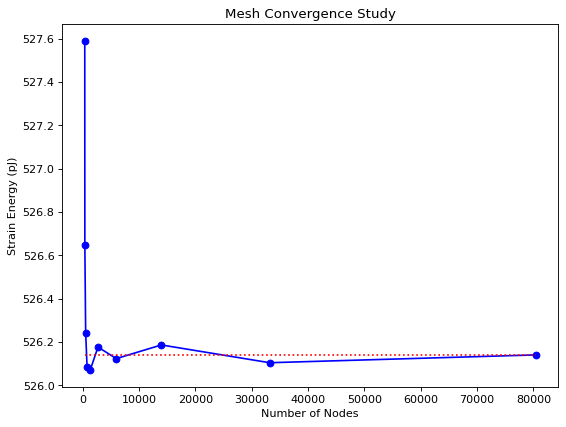

In [25]:
# convergence over global mesh size refinement
geo = Geometry()
mat = Material()  
# c_r = 20      # um
force = 100   # uN

# Define mesh convergence parameters
list_N_nodes = []
list_Ue = []

# element size: use log space since mesh converges logarithmically
esizes = np.logspace(1, -0.75, 10) # an array start at 1.25, ends at 0.6, log spaced in 20 intervals

# run the mesh convergence and output the results on the fly
for esize in esizes:
    sum_dict, N_nodes, converge = get_Ue(mat, geo, c_r, force, None, AESIZE = esize)
    list_N_nodes.append(N_nodes)
    print(f'#Nodes = {N_nodes};\t esize = {esize}')
#     mapdl.eplot(title='Element Plot', line_width=1, show_bounds=True, cpos="xy")

    list_Ue.append(sum_dict['UE'])

# plot convergence curve
    
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list_N_nodes, list_Ue, 'b-o')
plt.plot([list_N_nodes[0], list_N_nodes[-1]], [list_Ue[-1], list_Ue[-1]], 'r:')
plt.title('Mesh Convergence Study')
plt.xlabel('Number of Nodes')
plt.ylabel('Strain Energy (pJ)')
plt.show()

#Nodes = 44;	 refine_level = 0.0
#Nodes = 112;	 refine_level = 1.0
#Nodes = 209;	 refine_level = 2.0
#Nodes = 344;	 refine_level = 3.0
#Nodes = 455;	 refine_level = 4.0
#Nodes = 583;	 refine_level = 5.0


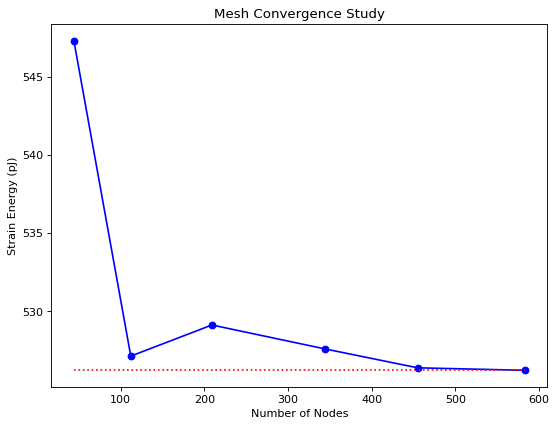

In [23]:
# convergence over local mesh size refinement level (0-5)
geo = Geometry()
mat = Material()  
c_r = 20      # um
force = 100   # uN

# Define mesh convergence parameters
list_N_nodes = []
list_Ue = []

list_refine_levels = np.linspace(0,5,6)

for refine_level in list_refine_levels:
    sum_dict, N_nodes, converge = get_Ue(mat, geo, c_r, force, None, AESIZE = 10, refine_lvl = int(refine_level))
    list_N_nodes.append(N_nodes)
    print(f'#Nodes = {N_nodes};\t refine_level = {refine_level}')
    list_Ue.append(sum_dict['UE'])
    
# check time for each analysis
# %timeit sum_dict, N_nodes, converge = get_Ue(mat, geo, c_r, force, AESIZE = 0.8)

# plot convergence curve
    
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list_N_nodes, list_Ue, 'b-o')
plt.plot([list_N_nodes[0], list_N_nodes[-1]], [list_Ue[-1], list_Ue[-1]], 'r:')
plt.title('Mesh Convergence Study')
plt.xlabel('Number of Nodes')
plt.ylabel('Strain Energy (pJ)')
plt.show()

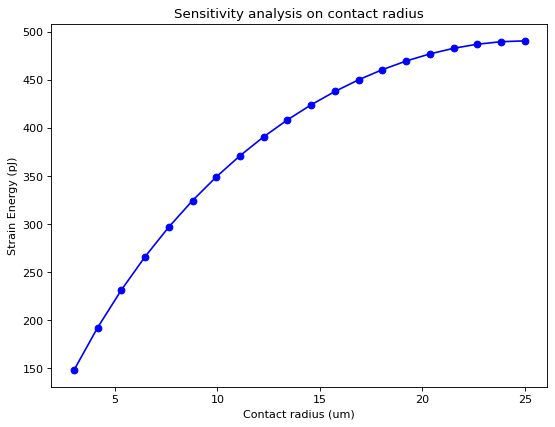

In [33]:
# sensitivity analysis on contact radius, with displacement constant
# test run the fiber
geo = Geometry()
mat = Material()  
esize = 0.8      # um


# Define mesh convergence parameters
# list_c_r = []
list_Ue = []

# element size: use log space since mesh converges logarithmically
list_c_r = np.linspace(3, 25, 20) # an array start at 1.4, ends at 0, log spaced in 20 intervals

for c_r in list_c_r:
    sum_dict, _ , _ = get_Ue(mat, geo, c_r, None, 10, AESIZE = esize)
    list_Ue.append(sum_dict["UE"])
    
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list_c_r, list_Ue, 'b-o')
plt.title('Sensitivity analysis on contact radius')
plt.xlabel('Contact radius (um)')
plt.ylabel('Strain Energy (pJ)')
plt.show()

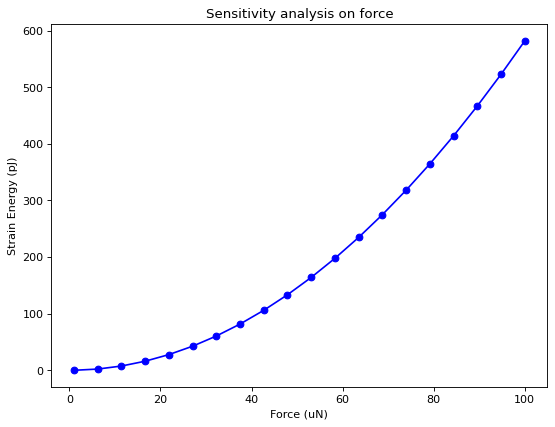

In [34]:
# sensitivity analysis on force
geo = Geometry()
mat = Material()  
esize = 0.8      # um
c_r = 15

list_Ue = []

list_force = np.linspace(1, 100, 20) 

for force in list_force:
    sum_dict, _, _ = get_Ue(mat, geo, c_r, force, None, AESIZE = esize)
    list_Ue.append(sum_dict["UE"])

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list_force, list_Ue, 'b-o')
plt.title('Sensitivity analysis on force')
plt.xlabel('Force (uN)')
plt.ylabel('Strain Energy (pJ)')
plt.show()

In [109]:
mapdl.show()
# mapdl.post1()
mapdl.pldisp(2)


PRODUCE DISPLACEMENT PLOT, KUND= 2

 CUMULATIVE DISPLAY NUMBER   1 WRITTEN TO FILE file.grph         - RASTER MODE.
 DISPLAY TITLE=

## Step 3 - Dynamic fiber tensile force routine

In [3]:
class Fiber:    # fiber object that calculates its own max adhesion and 

    def __init__(self, mat, geo, detach_step=5, disp_step=1):
        self.mat = mat
        self.geo = geo
        if geo.curve != []:                                 # radius of surface contact with rigid half surface
            self.c_r = geo.curve[0] + geo.diameter/2                        
        else:
            self.c_r = geo.diameter/2
        self.detach_step = detach_step
        self.disp_step = disp_step
        self.w_ad = mat.w_ad                                # work of adhesion between fiber and glass
        self.Ue = 0                                         # total elastic energy at current tensile load and contact area
        self.F_ad = 0                                       # current max tested adhesion strengh
        self.complete_detach = False                        # boolean to indicate complete detachment
        self.failed_line = None
        
    def Uelastic(self, displacement, c_r):       # update the total elastic energy in the fiber based on current tensile load
        sum_dict, _, converge = get_Ue(self.mat, self.geo, c_r, disp=displacement, detach_step = self.detach_step)        # update the Ue of fiber
#         print('c_r =', c_r)
        if not converge:
            self.complete_detach = True
            self.F_ad = 0
            self.failed_line = self.geo.curve
            return 0, 0, False 
        Ue = sum_dict['UE']
        force = sum_dict['Fy']
        return Ue, force, converge

    def find_F_ad(self):        # iteratively update F_ad via checking detachment until complete detachment
        displacement = 0        # potentially can be optimizied to save computation
        while self.complete_detach == False:
            displacement += self.disp_step
            self.check_detach(displacement, self.c_r)     
        return self.F_ad

    def check_detach(self, displacement, c_r):   # helper function to check for detachment using recursion
        if c_r-self.detach_step <= 0:    # terminal condition when fiber completely detached
#             print(f"detachment completed at {displacement}um\n")
            self.complete_detach = True
            return
        
        Ue_0, force_0, converge = self.Uelastic(displacement, c_r)                  # readout elastic energy of fiber at current contact_radius
        if not converge:
            return
        Ue_1, force_1, converge = self.Uelastic(displacement, c_r-self.detach_step)      # readout elastic energy of fiber at reduced contact_radius
        if not converge:
            return
        dUe = Ue_0 - Ue_1                                                 # calc elastic energy release rate by one-step-lookahead
        dUw = c_r*self.detach_step*self.w_ad            # calc surface energy gain rate by one-step-lookahead
        self.F_ad = max(self.F_ad, force_0)
        
#         print(f'at contact radius {c_r:.1f}um -> {c_r-self.detach_step:.1f}um, dUe = {dUe:.2f}pJ, dUw = {dUw:.2f}pJ')

        if dUe <= dUw:      # if elastic release < surface gain, detachment stops at the current contact radius
#             print(f"insufficient elastic energy to drive detachment at displacement={displacement}um\t radius={self.c_r}um\n")
            return
        
        else:
#             print(f"detachment progresses under displacement {displacement}um\n")
            self.c_r -= self.detach_step*100 # this is to skip the steps which are most likely to have detachment progressions
            self.check_detach(displacement, self.c_r)

In [8]:
mat = Material()
geo = Geometry()

sum_dict, _ = get_Ue(mat, geo, c_r=25, disp=10, detach_step = 10)
mapdl.post_processing.plot_nodal_eqv_stress(cpos="xy", cmap="magma")
print(sum_dict['UE'])

# sum_dict, _ = get_Ue(mat, geo, c_r=25, disp=10, detach_step = 10)
# mapdl.post_processing.plot_nodal_eqv_stress(cpos="xy", cmap="magma")
# print(sum_dict['UE'])

c_r original received as 30.00
max_stn: 10.0%;           disp: 10.05um;           F:  98.2uN;           Ue: 490.9;           #Node: 126


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

490.874


## Step 4 - Finite Difference Convergence

F_ad =  37.32(uN)
F_ad =  37.32(uN)
F_ad =  37.32(uN)
F_ad =  37.32(uN)
F_ad =  46.07(uN)
F_ad =  46.07(uN)
F_ad =  54.60(uN)
F_ad =  54.60(uN)
F_ad =  62.92(uN)
F_ad =  62.92(uN)
F_ad =  78.97(uN)
F_ad =  78.97(uN)
F_ad =  94.25(uN)
F_ad =  94.25(uN)
F_ad =  108.81(uN)
F_ad =  122.69(uN)
F_ad =  108.81(uN)
F_ad =  148.59(uN)
F_ad =  160.67(uN)
F_ad =  142.34(uN)


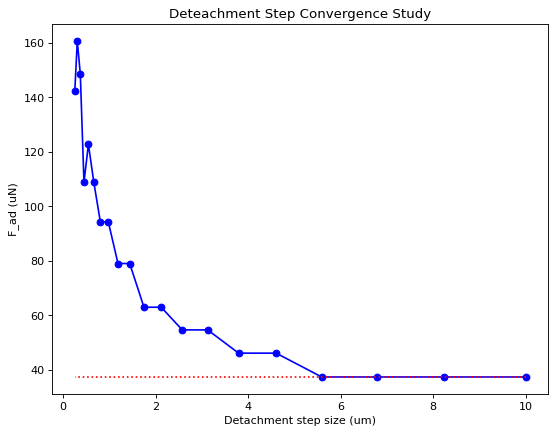

In [93]:
# test on finite difference stepsize - detachment step, mesh automatically adjusted
geo = Geometry()
mat = Material()  
disp_step =1

# Define mesh convergence parameters
list_F_ad = []

# element size: use log space since mesh converges logarithmically
list_detach_step = np.logspace(1, -0.6, 20) 

for detach_step in list_detach_step:
    fb = Fiber(mat, geo, detach_step=detach_step, disp_step =disp_step)
    F_ad = fb.find_F_ad()
#     mapdl.upcoord(1)
#     mapdl.eplot(cpos='xy')
#     mapdl.upcoord(-1)
    print(f'F_ad = {F_ad: 5.2f}(uN)')
    list_F_ad.append(F_ad)
    
# plot convergence curve
    
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list_detach_step, list_F_ad, 'b-o')
plt.plot([list_detach_step[0], list_detach_step[-1]], [list_F_ad[0], list_F_ad[0]], 'r:')
plt.title('Deteachment Step Convergence Study')
plt.xlabel('Detachment step size (um)')
plt.ylabel('F_ad (uN)')
plt.show()

at disp_step =  10.0, F_ad =  98.2(uN)
at disp_step =   7.0, F_ad =  137.2(uN)
at disp_step =   4.9, F_ad =  143.9(uN)
at disp_step =   3.4, F_ad =  100.6(uN)
at disp_step =   2.4, F_ad =  117.2(uN)
at disp_step =   1.7, F_ad =  98.3(uN)
at disp_step =   1.2, F_ad =  103.0(uN)
at disp_step =   0.8, F_ad =  104.0(uN)
at disp_step =   0.6, F_ad =  100.7(uN)
at disp_step =   0.4, F_ad =  101.6(uN)


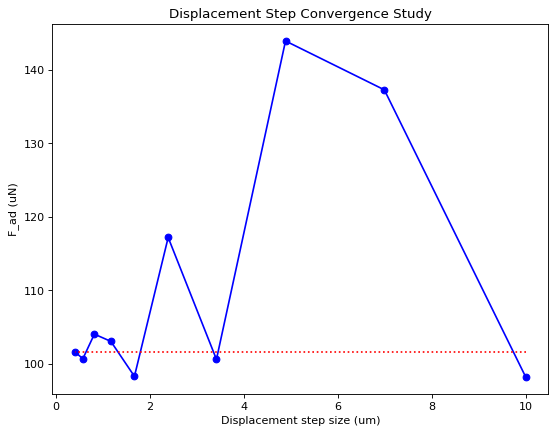

In [7]:
# test on finite difference steps - displacement step
geo = Geometry()
mat = Material()  
# c_r = 25      # um
# force = 100   # uN

# Define mesh convergence parameters
list_F_ad = []

# element size: use log space since mesh converges logarithmically
list_disp_step = np.logspace(1, -0.4, 10) 

for disp_step in list_disp_step:
    fb = Fiber(mat, geo, detach_step=0.8, disp_step=disp_step)
    F_ad = fb.find_F_ad()
    print(f'at disp_step = {disp_step: 5.1f} (um), F_ad = {F_ad: 5.1f}(uN)')
    list_F_ad.append(F_ad)
    
# check time for each analysis
# %timeit 

# plot convergence curve
    
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list_disp_step, list_F_ad, 'b-o')
plt.plot([list_disp_step[0], list_disp_step[-1]], [list_F_ad[-1], list_F_ad[-1]], 'r:')
plt.title('Displacement Step Convergence Study')
plt.xlabel('Displacement step size (um)')
plt.ylabel('F_ad (uN)')
plt.show()

## Step 5 - Fiber with Profile created by Fourier Series

In [4]:
# generating Fourier Coefficients and line
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from math import* #import all function from math

def Coefficient_Gen(pop_size, mode = 20, center_tolerance=1, max_amplitude=8):
    n = mode   
    tol = center_tolerance
    
    Ans = np.empty(shape = (0,20))
    Bns = np.empty(shape = (0,20))
#     print(Ans.shape, Ans[:,:6])
    
    while Ans[:,0].size < pop_size:
        An = np.expand_dims(np.array([random.uniform(-1, 1) for _ in range(n)]), axis = 0)
        Bn = np.expand_dims(np.array([random.uniform(-1, 1) for _ in range(n)]), axis = 0)
        line = to_Fourier(An, Bn)
        line_max = np.absolute(line).max()
        line_avg = np.average(line) 
        if line_avg<-tol or line_avg>tol or line_max>max_amplitude:
            continue
        Ans = np.vstack((Ans, An))
        Bns = np.vstack((Bns, Bn))
        DNAs = np.hstack((Ans, Bns))
#         print(Ans.shape)
    return DNAs
    
# array compatible
def to_Fourier(An, Bn, segment = 20):

    if An.shape == Bn.shape:
        n = An[0,:].size
    else:
        print('Error: coefficients size mismatch')
    
    x=np.arange(-np.pi,np.pi,2*np.pi/segment) #x axis has been chosen from –π to +π, value 
    x=np.expand_dims(x, 0)
    total = 0

    for i in range(n):
        if i==0.0:
            total+=An[:,i]/2 # in case n=0
            total=total[:,np.newaxis]
        else:
            total = total + An[:,i][:,np.newaxis]*np.cos(i*x)+Bn[:,i][:,np.newaxis]*np.sin(i*x)

#     plt.plot(x,total,'g')
#     plt.title("fourier series generated")
#     plt.show()

    return total


## Step 6 - GA to optimize the Fiber Curved Surface

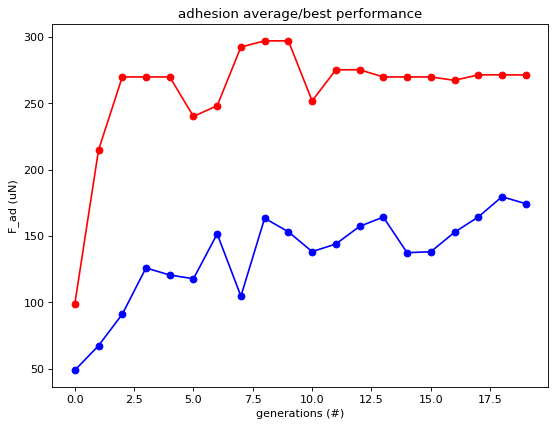

In [13]:
# line = lines[np.argmax(fitness), :]
# print(line)

# # reset mapdl
# mapdl.clear()
# mapdl.prep7()   

# # Define element attributes
# # keyoption 3 = 1 (axis-symmetric formulation)
# mapdl.et(1, "PLANE182", kop3=1)

# # create cross-sectional area of fiber

# line = line.tolist()
# n = len(line)
# segment = geo.height/(n-1)     
# mapdl.flst(3, n, 3)
# for i in range(n):
#     mapdl.k(i+2, line[i]+geo.diameter/2, i*segment)
#     mapdl.fitem(3, i+2)
# mapdl.run('BSPLIN, ,P51X')
# mapdl.cm("curved_edge", "LINE")
# mapdl.k(1,0,0) # starting at origin
# mapdl.k(n+2,0,geo.height) # ending at the top
# mapdl.lstr(1,2)
# mapdl.lstr(n+1,n+2)
# mapdl.lstr(n+2,1)
# mapdl.lplot('ALL',cpos="xy")
    
# plot curves

list_gens = range(0,20)

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list_gens, gen_average, 'b-o')
plt.plot(list_gens, gen_bestscore, 'r-o')
plt.title('adhesion average/best performance')
plt.xlabel('generations (#)')
plt.ylabel('F_ad (uN)')
plt.show()


import csv

with open('sample_4(1).csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(['average'])
    write.writerow(gen_average)
    write.writerow(['bestscore'])
    write.writerow(gen_bestscore)
    write.writerow(['best'])
    write.writerow(gen_best)
    write.writerow(['failed'])
    write.writerow(failed_lines)


F_ad_0 = 48.20
F_ad_1 = 27.43
F_ad_2 = 26.20
F_ad_3 = 56.56
F_ad_4 = 0.00
F_ad_5 = 26.68
F_ad_6 = 25.95
F_ad_7 = 57.88
F_ad_8 = 26.54
F_ad_9 = 75.17
gen0: avg=37.1, max=75.2
F_ad_0 = 35.82
F_ad_1 = 48.20
F_ad_2 = 50.74
F_ad_3 = 49.94
F_ad_4 = 121.68
F_ad_5 = 56.56
F_ad_6 = 27.43
F_ad_7 = 25.95
F_ad_8 = 40.11
F_ad_9 = 0.00
gen1: avg=45.6, max=121.7
F_ad_0 = 50.74
F_ad_1 = 50.74
F_ad_2 = 27.43
F_ad_3 = 52.47
F_ad_4 = 55.94
F_ad_5 = 50.74
F_ad_6 = 121.68
F_ad_7 = 121.68
F_ad_8 = 121.68
F_ad_9 = 53.22
gen2: avg=70.6, max=121.7
F_ad_0 = 121.68
F_ad_1 = 121.68
F_ad_2 = 121.68
F_ad_3 = 121.68
F_ad_4 = 53.22
F_ad_5 = 97.70
F_ad_6 = 121.68
F_ad_7 = 34.08
F_ad_8 = 121.68
F_ad_9 = 121.68
gen3: avg=103.7, max=121.7
F_ad_0 = 121.68
F_ad_1 = 121.68
F_ad_2 = 121.68
F_ad_3 = 121.68
F_ad_4 = 41.86
F_ad_5 = 121.68
F_ad_6 = 0.00
F_ad_7 = 157.71
F_ad_8 = 121.68
F_ad_9 = 121.68
gen4: avg=105.1, max=157.7
F_ad_0 = 121.68
F_ad_1 = 91.40
F_ad_2 = 33.66
F_ad_3 = 121.68
F_ad_4 = 103.60
F_ad_5 = 49.90
F_ad_6 = 1

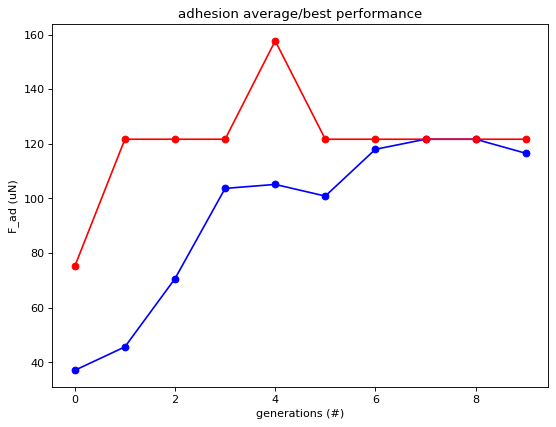

In [6]:
# test block for GA 1
N_GENERATIONS = 10         # number of generations
POP_SIZE = 10
DNA_SIZE = 40
CROSS_RATE = 0.8            # mating probability (DNA crossover)
MUTATION_RATE = 0.003       # mutation probability

 
pop = np.random.uniform(-1,1, size=(POP_SIZE, DNA_SIZE))   # initialize the pop DNA

class Material:

    def __init__(self, E_modulus = 500, nu=0.4, w_ad = 20):
        self.E_modulus = E_modulus*1e-3  # elasticu modulus: kPa -> uN/um^2
        self.nu = nu                     # poisson ratio: dimensionless
        self.w_ad = w_ad *1e-3           # work of adhesion: mJ/m^2 -> uN/um  

class Geometry:

    def __init__(self, height = 100, diameter=50, curve=[]):
        self.height = height        # fiber height: um
        self.diameter = diameter    # fiber average diameter: um
        self.curve = curve          # curved side profile, either None (straight edge) or 1D array of radius

def translateDNA(pop): # DNA samples to split into different gene groups, e.g. An, Bn
    
    An = pop[:,:int(DNA_SIZE/2)]
    Bn = pop[:,int(DNA_SIZE/2):]
    return An, Bn

def to_Fourier(An, Bn, segment = 20):

    if An.shape == Bn.shape:
        n = An[0,:].size
    else:
        print('Error: coefficients size mismatch')
    
    x=np.arange(-np.pi,np.pi,2*np.pi/segment) #x axis has been chosen from –π to +π, value 
    x=np.expand_dims(x, 0)
    total = 0

    for i in range(n):
        if i==0.0:
            total+=An[:,i]/2 # in case n=0
            total=total[:,np.newaxis]
        else:
            total = total + An[:,i][:,np.newaxis]*np.cos(i*x)+Bn[:,i][:,np.newaxis]*np.sin(i*x)
    return total

def F(lines): 
    F_ads = []
    for i, line in enumerate(lines.tolist()):
        geo = Geometry(curve = line)
        mat = Material()
        fb = Fiber(mat, geo)
        F_ad = fb.find_F_ad()
        print(f'F_ad_{i} = {F_ad:.2f}')
        F_ads.append(F_ad)
        if fb.failed_line != None:
            failed_lines.append(fb.failed_line) 
#         mapdl.eplot(title='element Plot', line_width=1, show_bounds=True, cpos="xy")
    return np.array(F_ads)     

def get_fitness(pred): 
    return pred + 1e-3 - np.min(pred)

def select(pop, fitness):    # nature selection wrt pop's fitness
    idx = np.random.choice(np.arange(POP_SIZE), size=POP_SIZE, replace=True,     
                           p=fitness/fitness.sum())
    return pop[idx]

def crossover(parent, pop):     # mating process (genes crossover)
    if np.random.rand() < CROSS_RATE:
        i_ = np.random.randint(0, POP_SIZE, size=1)                             # select a sample from pop
        cross_points = np.random.randint(0, 2, size=DNA_SIZE).astype(bool)      # generate crossover points = a 1D array of boolean with size of DNA_size used as mask
#         print(cross_points)
        parent[cross_points] = pop[i_, cross_points]                            # mating and produce one child
        # numpy array allows the indexing using boolean array for masking operation, the indexing array has to be of the same size as the main array
        
    return parent

def mutate(child):
    for point in range(DNA_SIZE):                                               # for every gene in the child
        if np.random.rand() < MUTATION_RATE:                                    # if throw a float dice between 0-1 and its value falls below mutation rate
            child[point] = random.uniform(-1,1)                        
    return child

# GA begins here:
pop = Coefficient_Gen(pop_size = POP_SIZE)   # initialize the pop DNA

gen_average=[]
gen_bestscore=[]
gen_best=[]
failed_lines = []

for i in range(N_GENERATIONS):
    An, Bn = translateDNA(pop)
    lines = to_Fourier(An, Bn)
#     line_max = np.absolute(lines).max()
#     line_avg = np.average(lines) 
#     if line_max > 8 or line_avg < -1 or line_avg > 1:
#         print('line generation error')
    F_values = F(lines)

    
    # GA part (evolution)
    fitness = get_fitness(F_values)                         # calc fitness of all outcome values
    gen_average.append(np.average(F_values))  
    gen_bestscore.append(np.max(F_values)) 
    gen_best.append(lines[np.argmax(fitness), :])
    
    print(f'gen{i}: avg={gen_average[i]:.1f}, max={gen_bestscore[i]:.1f}')  # printout the DNA of the most fitted sample
    pop = select(pop, fitness)                              # select 1D array of children with same number as parent, based on probability derived from fitness
    pop_copy = pop.copy()
    for parent in pop:                                      # for every sample in the population
        child = crossover(parent, pop_copy)                 # marry it with another random sample in the population and make a child
        child = mutate(child)                               # mutate random genes in the child
        parent[:] = child    

list_gens = range(0,N_GENERATIONS)

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list_gens, gen_average, 'b-o')
plt.plot(list_gens, gen_bestscore, 'r-o')
plt.title('adhesion average/best performance')
plt.xlabel('generations (#)')
plt.ylabel('F_ad (uN)')
plt.show()


import csv

with open('sample_1.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(['average'])
    write.writerow(gen_average)
    write.writerow(['bestscore'])
    write.writerow(gen_bestscore)
    write.writerow(['best'])
    write.writerow(gen_best)
    write.writerow(['failed'])
    write.writerow(failed_lines)

F_ad_0 = 35.18
F_ad_1 = 109.82
F_ad_2 = 42.13
F_ad_3 = 35.12
F_ad_4 = 44.36
F_ad_5 = 27.51
F_ad_6 = 38.17
F_ad_7 = 33.79
F_ad_8 = 64.33
F_ad_9 = 26.84
F_ad_10 = 41.30
F_ad_11 = 49.44
F_ad_12 = 39.17
F_ad_13 = 157.99
F_ad_14 = 26.38
F_ad_15 = 73.64
F_ad_16 = 43.80
F_ad_17 = 26.07
F_ad_18 = 26.88
F_ad_19 = 42.67
gen0: avg=49.2, max=158.0
F_ad_0 = 157.99
F_ad_1 = 27.21
F_ad_2 = 109.82
F_ad_3 = 51.36
F_ad_4 = 87.95
F_ad_5 = 51.90
F_ad_6 = 42.67
F_ad_7 = 171.61
F_ad_8 = 73.55
F_ad_9 = 58.41
F_ad_10 = 69.60
F_ad_11 = 58.47
F_ad_12 = 42.67
F_ad_13 = 73.64
F_ad_14 = 49.44
F_ad_15 = 109.82
F_ad_16 = 51.82
F_ad_17 = 35.36
F_ad_18 = 52.27
F_ad_19 = 238.13
gen1: avg=80.7, max=238.1
F_ad_0 = 87.96
F_ad_1 = 61.65
F_ad_2 = 109.44
F_ad_3 = 109.82
F_ad_4 = 0.00
F_ad_5 = 157.99
F_ad_6 = 128.92
F_ad_7 = 51.90
F_ad_8 = 87.95
F_ad_9 = 73.22
F_ad_10 = 35.28
F_ad_11 = 90.48
F_ad_12 = 67.76
F_ad_13 = 51.54
F_ad_14 = 81.94
F_ad_15 = 141.75
F_ad_16 = 73.72
F_ad_17 = 66.43
F_ad_18 = 43.45
F_ad_19 = 85.96
gen2: a

F_ad_15 = 190.49
F_ad_16 = 196.18
F_ad_17 = 147.48
F_ad_18 = 198.70
F_ad_19 = 225.01
gen19: avg=208.5, max=291.9


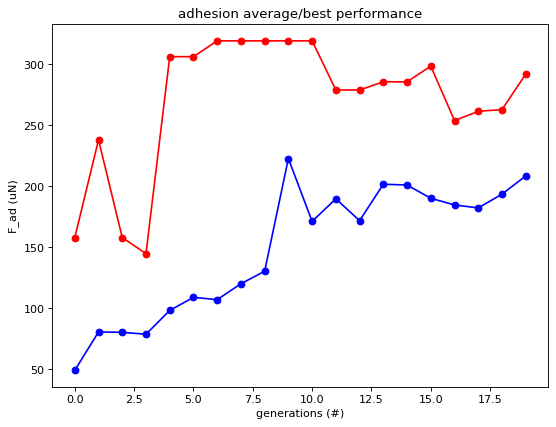

In [25]:
# test block for GA 2
N_GENERATIONS = 20         # number of generations
POP_SIZE = 20
DNA_SIZE = 40
CROSS_RATE = 0.8            # mating probability (DNA crossover)
MUTATION_RATE = 0.003       # mutation probability

 
pop = np.random.uniform(-1,1, size=(POP_SIZE, DNA_SIZE))   # initialize the pop DNA

class Material:

    def __init__(self, E_modulus = 500, nu=0.4, w_ad = 20):
        self.E_modulus = E_modulus*1e-3  # elasticu modulus: kPa -> uN/um^2
        self.nu = nu                     # poisson ratio: dimensionless
        self.w_ad = w_ad *1e-3           # work of adhesion: mJ/m^2 -> uN/um  

class Geometry:

    def __init__(self, height = 100, diameter=50, curve=[]):
        self.height = height        # fiber height: um
        self.diameter = diameter    # fiber average diameter: um
        self.curve = curve          # curved side profile, either None (straight edge) or 1D array of radius

def translateDNA(pop): # DNA samples to split into different gene groups, e.g. An, Bn
    
    An = pop[:,:int(DNA_SIZE/2)]
    Bn = pop[:,int(DNA_SIZE/2):]
    return An, Bn

def to_Fourier(An, Bn, segment = 20):

    if An.shape == Bn.shape:
        n = An[0,:].size
    else:
        print('Error: coefficients size mismatch')
    
    x=np.arange(-np.pi,np.pi,2*np.pi/segment) #x axis has been chosen from –π to +π, value 
    x=np.expand_dims(x, 0)
    total = 0

    for i in range(n):
        if i==0.0:
            total+=An[:,i]/2 # in case n=0
            total=total[:,np.newaxis]
        else:
            total = total + An[:,i][:,np.newaxis]*np.cos(i*x)+Bn[:,i][:,np.newaxis]*np.sin(i*x)
    return total

def F(lines): 
    F_ads = []
    for i, line in enumerate(lines.tolist()):
        geo = Geometry(curve = line)
        mat = Material()
        fb = Fiber(mat, geo)
        F_ad = fb.find_F_ad()
        print(f'F_ad_{i} = {F_ad:.2f}')
        F_ads.append(F_ad) 
#         mapdl.eplot(title='element Plot', line_width=1, show_bounds=True, cpos="xy")
    return np.array(F_ads)     

def get_fitness(pred): 
    return pred + 1e-3 - np.min(pred)

def select(pop, fitness):    # nature selection wrt pop's fitness
    idx = np.random.choice(np.arange(POP_SIZE), size=POP_SIZE, replace=True,     
                           p=fitness/fitness.sum())
    return pop[idx]

def crossover(parent, pop):     # mating process (genes crossover)
    if np.random.rand() < CROSS_RATE:
        i_ = np.random.randint(0, POP_SIZE, size=1)                             # select a sample from pop
        cross_points = np.random.randint(0, 2, size=DNA_SIZE).astype(bool)      # generate crossover points = a 1D array of boolean with size of DNA_size used as mask
#         print(cross_points)
        parent[cross_points] = pop[i_, cross_points]                            # mating and produce one child
        # numpy array allows the indexing using boolean array for masking operation, the indexing array has to be of the same size as the main array
        
    return parent

def mutate(child):
    for point in range(DNA_SIZE):                                               # for every gene in the child
        if np.random.rand() < MUTATION_RATE:                                    # if throw a float dice between 0-1 and its value falls below mutation rate
            child[point] = random.uniform(-1,1)                        
    return child

# GA begins here:
pop = Coefficient_Gen(pop_size = POP_SIZE)   # initialize the pop DNA

gen_average=[]
gen_bestscore=[]
gen_best=[]
failed_lines = []

for i in range(N_GENERATIONS):
    An, Bn = translateDNA(pop)
    lines = to_Fourier(An, Bn)
#     line_max = np.absolute(lines).max()
#     line_avg = np.average(lines) 
#     if line_max > 8 or line_avg < -1 or line_avg > 1:
#         print('line generation error')
    F_values = F(lines)

    
    # GA part (evolution)
    fitness = get_fitness(F_values)                         # calc fitness of all outcome values
    gen_average.append(np.average(F_values))  
    gen_bestscore.append(np.max(F_values)) 
    gen_best.append(lines[np.argmax(fitness), :])
    
    print(f'gen{i}: avg={gen_average[i]:.1f}, max={gen_bestscore[i]:.1f}')  # printout the DNA of the most fitted sample
    pop = select(pop, fitness)                              # select 1D array of children with same number as parent, based on probability derived from fitness
    pop_copy = pop.copy()
    for parent in pop:                                      # for every sample in the population
        child = crossover(parent, pop_copy)                 # marry it with another random sample in the population and make a child
        child = mutate(child)                               # mutate random genes in the child
        parent[:] = child    

list_gens = range(0,N_GENERATIONS)

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list_gens, gen_average, 'b-o')
plt.plot(list_gens, gen_bestscore, 'r-o')
plt.title('adhesion average/best performance')
plt.xlabel('generations (#)')
plt.ylabel('F_ad (uN)')
plt.show()


import csv

with open('sample_2.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(['average'])
    write.writerow(gen_average)
    write.writerow(['bestscore'])
    write.writerow(gen_bestscore)
    write.writerow(['best'])
    write.writerow(gen_best)
    write.writerow(['failed'])
    write.writerow(failed_lines)

F_ad_0 = 26.37
F_ad_1 = 26.31
F_ad_2 = 44.19
F_ad_3 = 155.99
F_ad_4 = 58.20
F_ad_5 = 42.44
F_ad_6 = 41.84
F_ad_7 = 60.48
F_ad_8 = 103.37
F_ad_9 = 52.68
F_ad_10 = 149.34
F_ad_11 = 0.00
F_ad_12 = 28.07
F_ad_13 = 33.75
F_ad_14 = 44.16
F_ad_15 = 32.48
F_ad_16 = 72.06
F_ad_17 = 73.88
F_ad_18 = 57.52
F_ad_19 = 173.20
F_ad_20 = 35.29
F_ad_21 = 26.27
F_ad_22 = 108.40
F_ad_23 = 27.35
F_ad_24 = 42.64
F_ad_25 = 36.55
F_ad_26 = 49.75
F_ad_27 = 34.17
F_ad_28 = 34.19
F_ad_29 = 99.97
gen0: avg=59.0, max=173.2, best =[ 2.76219041 -3.39836352 -1.02403202 -0.09634105  3.16648915  2.26675368
 -0.10158281 -4.27673545 -4.87007379  2.45748662 -0.65031001 -1.06124786
  1.01559597  5.85167494  4.27984615 -0.86896152  1.09760753  3.9773808
 -2.60802733 -0.08862391]
F_ad_0 = 57.55
F_ad_1 = 41.48
F_ad_2 = 72.62
F_ad_3 = 108.40
F_ad_4 = 68.45
F_ad_5 = 35.07
F_ad_6 = 86.00
F_ad_7 = 90.98
F_ad_8 = 66.68
F_ad_9 = 57.52
F_ad_10 = 49.36
F_ad_11 = 51.70
F_ad_12 = 34.19
F_ad_13 = 34.17
F_ad_14 = 149.34
F_ad_15 = 41.34
F

F_ad_13 = 66.31
F_ad_14 = 117.88
F_ad_15 = 223.58
F_ad_16 = 101.17
F_ad_17 = 81.04
F_ad_18 = 174.06
F_ad_19 = 71.84
F_ad_20 = 106.31
F_ad_21 = 127.47
F_ad_22 = 241.06
F_ad_23 = 206.11
F_ad_24 = 51.79
F_ad_25 = 106.31
F_ad_26 = 184.40
F_ad_27 = 64.49
F_ad_28 = 210.66
F_ad_29 = 140.83
gen9: avg=119.8, max=241.1, best =[ 3.56890719 -3.33353996  2.18113222 -0.51319148  2.29582425 -1.48484007
 -5.23355154  1.17044734  0.04102758  4.13068031 -3.76208916 -1.84993731
  0.00945163 -3.82679642  1.69516019 -3.63266651  5.47108828 -0.74739049
  4.43193916  3.6673648 ]
F_ad_0 = 203.98
F_ad_1 = 184.69
F_ad_2 = 129.31
F_ad_3 = 64.40
F_ad_4 = 174.02
F_ad_5 = 101.17
F_ad_6 = 126.23
F_ad_7 = 200.50
F_ad_8 = 86.59
F_ad_9 = 0.00
F_ad_10 = 72.70
F_ad_11 = 140.83
F_ad_12 = 142.39
F_ad_13 = 146.26
F_ad_14 = 206.11
F_ad_15 = 80.07
F_ad_16 = 111.96
F_ad_17 = 0.00
F_ad_18 = 135.64
F_ad_19 = 92.96
F_ad_20 = 299.00
F_ad_21 = 232.22
F_ad_22 = 202.47
F_ad_23 = 210.66
F_ad_24 = 70.70
F_ad_25 = 180.15
F_ad_26 = 151.8

F_ad_0 = 154.24
F_ad_1 = 101.72
F_ad_2 = 143.72
F_ad_3 = 220.85
F_ad_4 = 75.85
F_ad_5 = 149.53
F_ad_6 = 187.11
F_ad_7 = 95.34
F_ad_8 = 137.36
F_ad_9 = 145.41
F_ad_10 = 83.37
F_ad_11 = 145.69
F_ad_12 = 110.08
F_ad_13 = 73.03
F_ad_14 = 74.54
F_ad_15 = 138.74
F_ad_16 = 80.41
F_ad_17 = 187.31
F_ad_18 = 131.22
F_ad_19 = 148.96
F_ad_20 = 0.00
F_ad_21 = 106.41
F_ad_22 = 129.16
F_ad_23 = 182.12
F_ad_24 = 131.16
F_ad_25 = 156.36
F_ad_26 = 104.41
F_ad_27 = 148.96
F_ad_28 = 0.00
F_ad_29 = 238.31
gen19: avg=126.0, max=238.3, best =[ 2.42029467 -4.37964983 -1.75919545 -0.7860596   0.01117859  0.19121257
 -0.13697427 -3.22489438  3.82460331  2.66238558  0.33313571  1.29776363
  2.22428787  0.11286622 -0.92085445 -3.80651813  1.38821641  1.24598991
  4.53138337  1.4842202 ]
F_ad_0 = 145.41
F_ad_1 = 60.41
F_ad_2 = 254.58
F_ad_3 = 0.00
F_ad_4 = 215.12
F_ad_5 = 80.24
F_ad_6 = 130.87
F_ad_7 = 82.22
F_ad_8 = 154.24
F_ad_9 = 187.31
F_ad_10 = 229.79
F_ad_11 = 81.32
F_ad_12 = 74.54
F_ad_13 = 197.29
F_ad_14 =

F_ad_0 = 268.38
F_ad_1 = 191.71
F_ad_2 = 195.04
F_ad_3 = 176.30
F_ad_4 = 268.38
F_ad_5 = 155.01
F_ad_6 = 300.08
F_ad_7 = 268.38
F_ad_8 = 179.73
F_ad_9 = 0.00
F_ad_10 = 248.54
F_ad_11 = 181.32
F_ad_12 = 206.03
F_ad_13 = 191.77
F_ad_14 = 235.81
F_ad_15 = 153.97
F_ad_16 = 185.69
F_ad_17 = 176.30
F_ad_18 = 265.33
F_ad_19 = 268.98
F_ad_20 = 235.81
F_ad_21 = 208.61
F_ad_22 = 268.98
F_ad_23 = 248.67
F_ad_24 = 182.87
F_ad_25 = 268.98
F_ad_26 = 248.54
F_ad_27 = 214.50
F_ad_28 = 191.77
F_ad_29 = 177.27
gen29: avg=212.1, max=300.1, best =[ 4.8254092  -2.4131509  -0.88280534 -3.21184745 -0.56530209  1.3405326
  1.36799754 -2.11574389  1.53498155  1.3524861  -0.17182791  1.00938752
  2.43438133 -1.70008168 -0.81844339 -2.95959108  1.63911087  1.25301834
  2.55257401  2.24230661]


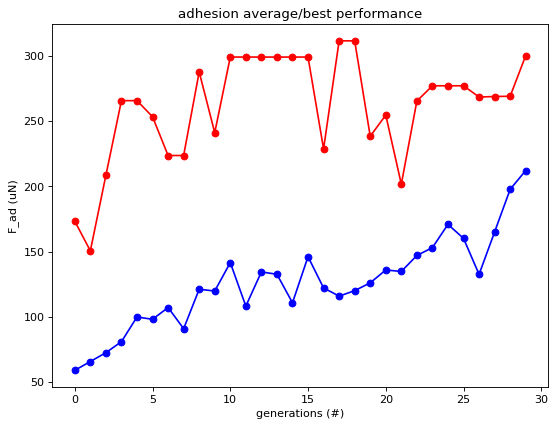

In [26]:
# test block for GA 3
N_GENERATIONS = 30         # number of generations
POP_SIZE = 30
DNA_SIZE = 40
CROSS_RATE = 0.8            # mating probability (DNA crossover)
MUTATION_RATE = 0.003       # mutation probability

 
pop = np.random.uniform(-1,1, size=(POP_SIZE, DNA_SIZE))   # initialize the pop DNA

class Material:

    def __init__(self, E_modulus = 500, nu=0.4, w_ad = 20):
        self.E_modulus = E_modulus*1e-3  # elasticu modulus: kPa -> uN/um^2
        self.nu = nu                     # poisson ratio: dimensionless
        self.w_ad = w_ad *1e-3           # work of adhesion: mJ/m^2 -> uN/um  

class Geometry:

    def __init__(self, height = 100, diameter=50, curve=[]):
        self.height = height        # fiber height: um
        self.diameter = diameter    # fiber average diameter: um
        self.curve = curve          # curved side profile, either None (straight edge) or 1D array of radius

def translateDNA(pop): # DNA samples to split into different gene groups, e.g. An, Bn
    
    An = pop[:,:int(DNA_SIZE/2)]
    Bn = pop[:,int(DNA_SIZE/2):]
    return An, Bn

def to_Fourier(An, Bn, segment = 20):

    if An.shape == Bn.shape:
        n = An[0,:].size
    else:
        print('Error: coefficients size mismatch')
    
    x=np.arange(-np.pi,np.pi,2*np.pi/segment) #x axis has been chosen from –π to +π, value 
    x=np.expand_dims(x, 0)
    total = 0

    for i in range(n):
        if i==0.0:
            total+=An[:,i]/2 # in case n=0
            total=total[:,np.newaxis]
        else:
            total = total + An[:,i][:,np.newaxis]*np.cos(i*x)+Bn[:,i][:,np.newaxis]*np.sin(i*x)
    return total

def F(lines): 
    F_ads = []
    for i, line in enumerate(lines.tolist()):
        geo = Geometry(curve = line)
        mat = Material()
        fb = Fiber(mat, geo)
        F_ad = fb.find_F_ad()
        print(f'F_ad_{i} = {F_ad:.2f}')
        F_ads.append(F_ad) 
#         mapdl.eplot(title='element Plot', line_width=1, show_bounds=True, cpos="xy")
    return np.array(F_ads)     

def get_fitness(pred): 
    return pred + 1e-3 - np.min(pred)

def select(pop, fitness):    # nature selection wrt pop's fitness
    idx = np.random.choice(np.arange(POP_SIZE), size=POP_SIZE, replace=True,     
                           p=fitness/fitness.sum())
    return pop[idx]

def crossover(parent, pop):     # mating process (genes crossover)
    if np.random.rand() < CROSS_RATE:
        i_ = np.random.randint(0, POP_SIZE, size=1)                             # select a sample from pop
        cross_points = np.random.randint(0, 2, size=DNA_SIZE).astype(bool)      # generate crossover points = a 1D array of boolean with size of DNA_size used as mask
#         print(cross_points)
        parent[cross_points] = pop[i_, cross_points]                            # mating and produce one child
        # numpy array allows the indexing using boolean array for masking operation, the indexing array has to be of the same size as the main array
        
    return parent

def mutate(child):
    for point in range(DNA_SIZE):                                               # for every gene in the child
        if np.random.rand() < MUTATION_RATE:                                    # if throw a float dice between 0-1 and its value falls below mutation rate
            child[point] = random.uniform(-1,1)                        
    return child

# GA begins here:
pop = Coefficient_Gen(pop_size = POP_SIZE)   # initialize the pop DNA

gen_average=[]
gen_bestscore=[]
gen_best=[]
failed_lines = []

for i in range(N_GENERATIONS):
    An, Bn = translateDNA(pop)
    lines = to_Fourier(An, Bn)
#     line_max = np.absolute(lines).max()
#     line_avg = np.average(lines) 
#     if line_max > 8 or line_avg < -1 or line_avg > 1:
#         print('line generation error')
    F_values = F(lines)

    
    # GA part (evolution)
    fitness = get_fitness(F_values)                         # calc fitness of all outcome values
    gen_average.append(np.average(F_values))  
    gen_bestscore.append(np.max(F_values)) 
    gen_best.append(lines[np.argmax(fitness), :])
    
    print(f'gen{i}: avg={gen_average[i]:.1f}, max={gen_bestscore[i]:.1f}, best ={gen_best[i]}')  # printout the DNA of the most fitted sample
    pop = select(pop, fitness)                              # select 1D array of children with same number as parent, based on probability derived from fitness
    pop_copy = pop.copy()
    for parent in pop:                                      # for every sample in the population
        child = crossover(parent, pop_copy)                 # marry it with another random sample in the population and make a child
        child = mutate(child)                               # mutate random genes in the child
        parent[:] = child    
        
list_gens = range(0,N_GENERATIONS)

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list_gens, gen_average, 'b-o')
plt.plot(list_gens, gen_bestscore, 'r-o')
plt.title('adhesion average/best performance')
plt.xlabel('generations (#)')
plt.ylabel('F_ad (uN)')
plt.show()

import csv

with open('sample_3.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(['average'])
    write.writerow(gen_average)
    write.writerow(['bestscore'])
    write.writerow(gen_bestscore)
    write.writerow(['best'])
    write.writerow(gen_best)
    write.writerow(['failed'])
    write.writerow(failed_lines)

In [ ]:
# test block for GA 5
N_GENERATIONS = 50         # number of generations
POP_SIZE = 50
DNA_SIZE = 40
CROSS_RATE = 0.8            # mating probability (DNA crossover)
MUTATION_RATE = 0.003       # mutation probability

 
pop = np.random.uniform(-1,1, size=(POP_SIZE, DNA_SIZE))   # initialize the pop DNA

class Material:

    def __init__(self, E_modulus = 500, nu=0.4, w_ad = 20):
        self.E_modulus = E_modulus*1e-3  # elasticu modulus: kPa -> uN/um^2
        self.nu = nu                     # poisson ratio: dimensionless
        self.w_ad = w_ad *1e-3           # work of adhesion: mJ/m^2 -> uN/um  

class Geometry:

    def __init__(self, height = 100, diameter=50, curve=[]):
        self.height = height        # fiber height: um
        self.diameter = diameter    # fiber average diameter: um
        self.curve = curve          # curved side profile, either None (straight edge) or 1D array of radius

def translateDNA(pop): # DNA samples to split into different gene groups, e.g. An, Bn
    
    An = pop[:,:int(DNA_SIZE/2)]
    Bn = pop[:,int(DNA_SIZE/2):]
    return An, Bn

def to_Fourier(An, Bn, segment = 20):

    if An.shape == Bn.shape:
        n = An[0,:].size
    else:
        print('Error: coefficients size mismatch')
    
    x=np.arange(-np.pi,np.pi,2*np.pi/segment) #x axis has been chosen from –π to +π, value 
    x=np.expand_dims(x, 0)
    total = 0

    for i in range(n):
        if i==0.0:
            total+=An[:,i]/2 # in case n=0
            total=total[:,np.newaxis]
        else:
            total = total + An[:,i][:,np.newaxis]*np.cos(i*x)+Bn[:,i][:,np.newaxis]*np.sin(i*x)
    return total

def F(lines): 
    F_ads = []
    for i, line in enumerate(lines.tolist()):
        geo = Geometry(curve = line)
        mat = Material()
        fb = Fiber(mat, geo)
        F_ad = fb.find_F_ad()
        print(f'F_ad_{i} = {F_ad:.2f}')
        F_ads.append(F_ad) 
#         mapdl.eplot(title='element Plot', line_width=1, show_bounds=True, cpos="xy")
    return np.array(F_ads)     

def get_fitness(pred): 
    return pred + 1e-3 - np.min(pred)

def select(pop, fitness):    # nature selection wrt pop's fitness
    idx = np.random.choice(np.arange(POP_SIZE), size=POP_SIZE, replace=True,     
                           p=fitness/fitness.sum())
    return pop[idx]

def crossover(parent, pop):     # mating process (genes crossover)
    if np.random.rand() < CROSS_RATE:
        i_ = np.random.randint(0, POP_SIZE, size=1)                             # select a sample from pop
        cross_points = np.random.randint(0, 2, size=DNA_SIZE).astype(bool)      # generate crossover points = a 1D array of boolean with size of DNA_size used as mask
#         print(cross_points)
        parent[cross_points] = pop[i_, cross_points]                            # mating and produce one child
        # numpy array allows the indexing using boolean array for masking operation, the indexing array has to be of the same size as the main array
        
    return parent

def mutate(child):
    for point in range(DNA_SIZE):                                               # for every gene in the child
        if np.random.rand() < MUTATION_RATE:                                    # if throw a float dice between 0-1 and its value falls below mutation rate
            child[point] = random.uniform(-1,1)                        
    return child

# GA begins here:
pop = Coefficient_Gen(pop_size = POP_SIZE)   # initialize the pop DNA

gen_average=[]
gen_bestscore=[]
gen_best=[]
failed_lines = []
for i in range(N_GENERATIONS):
    An, Bn = translateDNA(pop)
    lines = to_Fourier(An, Bn)
#     line_max = np.absolute(lines).max()
#     line_avg = np.average(lines) 
#     if line_max > 8 or line_avg < -1 or line_avg > 1:
#         print('line generation error')
    F_values = F(lines)

    
    # GA part (evolution)
    fitness = get_fitness(F_values)                         # calc fitness of all outcome values
    gen_average.append(np.average(F_values))  
    gen_bestscore.append(np.max(F_values)) 
    gen_best.append(lines[np.argmax(fitness), :])
    
    print(f'gen{i}: avg={gen_average[i]:.1f}, max={gen_bestscore[i]:.1f}, best ={gen_best[i]}')  # printout the DNA of the most fitted sample
    pop = select(pop, fitness)                              # select 1D array of children with same number as parent, based on probability derived from fitness
    pop_copy = pop.copy()
    for parent in pop:                                      # for every sample in the population
        child = crossover(parent, pop_copy)                 # marry it with another random sample in the population and make a child
        child = mutate(child)                               # mutate random genes in the child
        parent[:] = child    

list_gens = range(0,N_GENERATIONS)

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list_gens, gen_average, 'b-o')
plt.plot(list_gens, gen_bestscore, 'r-o')
plt.title('adhesion average/best performance')
plt.xlabel('generations (#)')
plt.ylabel('F_ad (uN)')
plt.show()

import csv

with open('sample_5.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(['average'])
    write.writerow(gen_average)
    write.writerow(['bestscore'])
    write.writerow(gen_bestscore)
    write.writerow(['best'])
    write.writerow(gen_best)
    write.writerow(['failed'])
    write.writerow(failed_lines)

F_ad_0 = 41.39
F_ad_1 = 35.02
F_ad_2 = 33.32
F_ad_3 = 26.03
F_ad_4 = 43.26
F_ad_5 = 51.70
F_ad_6 = 34.40
F_ad_7 = 51.44
F_ad_8 = 25.17
F_ad_9 = 0.00
F_ad_10 = 26.23
F_ad_11 = 60.16
F_ad_12 = 26.93
F_ad_13 = 25.26
F_ad_14 = 0.00
F_ad_15 = 28.12
F_ad_16 = 55.48
F_ad_17 = 90.22
F_ad_18 = 25.58
F_ad_19 = 42.12
F_ad_20 = 27.35
F_ad_21 = 40.26
F_ad_22 = 26.10
F_ad_23 = 65.62
F_ad_24 = 66.42
F_ad_25 = 65.96
F_ad_26 = 33.57
F_ad_27 = 76.83
F_ad_28 = 0.00
F_ad_29 = 79.43
F_ad_30 = 96.32
F_ad_31 = 33.14
F_ad_32 = 71.70
F_ad_33 = 52.01
F_ad_34 = 159.48
F_ad_35 = 90.13
F_ad_36 = 77.15
F_ad_37 = 98.00
F_ad_38 = 51.05
F_ad_39 = 50.37
F_ad_40 = 50.59
F_ad_41 = 25.91
F_ad_42 = 51.93
F_ad_43 = 0.00
F_ad_44 = 131.29
F_ad_45 = 27.69
F_ad_46 = 0.00
F_ad_47 = 50.17
F_ad_48 = 58.01
F_ad_49 = 154.43
gen0: avg=50.7, max=159.5, best =[ 1.89969316 -3.89344025 -0.51953759 -5.93274793 -0.46640223  0.8054599
  2.38450432  1.46513179 -2.30671014 -2.86774914 -0.41141459 -0.31295332
  0.10815048  3.90315348  3.673660

F_ad_33 = 59.18
F_ad_34 = 257.88
F_ad_35 = 257.88
F_ad_36 = 43.20
F_ad_37 = 159.81
F_ad_38 = 80.82
F_ad_39 = 45.03
F_ad_40 = 42.20
F_ad_41 = 205.39
F_ad_42 = 273.16
F_ad_43 = 44.91
F_ad_44 = 202.54
F_ad_45 = 237.27
F_ad_46 = 0.00
F_ad_47 = 226.71
F_ad_48 = 52.82
F_ad_49 = 0.00
gen6: avg=115.0, max=273.2, best =[ 4.67377306 -2.38229617  1.93575011 -2.50191251  1.09111318 -1.74274094
  0.85209656  5.55686944  1.63513975 -1.93555355 -3.03198735 -2.34908038
 -1.23495327  0.83733184  2.49707403 -2.01133336  1.34453129  2.27797678
  2.64198488  0.66261944]
F_ad_0 = 0.00
F_ad_1 = 109.38
F_ad_2 = 59.28
F_ad_3 = 142.58
F_ad_4 = 257.88
F_ad_5 = 195.28
F_ad_6 = 230.76
F_ad_7 = 59.54
F_ad_8 = 0.00
F_ad_9 = 87.77
F_ad_10 = 242.85
F_ad_11 = 120.27
F_ad_12 = 61.22
F_ad_13 = 202.34
F_ad_14 = 228.91
F_ad_15 = 273.16
F_ad_16 = 86.68
F_ad_17 = 42.20
F_ad_18 = 75.69
F_ad_19 = 0.00
F_ad_20 = 248.77
F_ad_21 = 257.88
F_ad_22 = 75.32
F_ad_23 = 138.59
F_ad_24 = 113.94
F_ad_25 = 115.56
F_ad_26 = 120.24
F_ad_27 

F_ad_16 = 280.01
F_ad_17 = 268.39
F_ad_18 = 111.30
F_ad_19 = 268.39
F_ad_20 = 116.02
F_ad_21 = 0.00
F_ad_22 = 151.69
F_ad_23 = 262.21
F_ad_24 = 264.99
F_ad_25 = 226.46
F_ad_26 = 90.95
F_ad_27 = 104.63
F_ad_28 = 0.00
F_ad_29 = 74.51
F_ad_30 = 51.06
F_ad_31 = 166.54
F_ad_32 = 97.18
F_ad_33 = 0.00
F_ad_34 = 83.80
F_ad_35 = 0.00
F_ad_36 = 42.98
F_ad_37 = 74.27
F_ad_38 = 209.40
F_ad_39 = 69.15
F_ad_40 = 0.00
F_ad_41 = 97.35
F_ad_42 = 173.88
F_ad_43 = 191.32
F_ad_44 = 74.13
F_ad_45 = 0.00
F_ad_46 = 141.30
F_ad_47 = 117.12
F_ad_48 = 205.76
F_ad_49 = 133.92
gen12: avg=125.5, max=280.0, best =[ 3.92663087 -3.17238868 -2.15714065 -4.12014641 -0.47722739 -0.19243884
  4.64345939 -0.85636088  1.76756308 -3.35699476  1.46032964  1.32544175
  0.18947304  2.00462941  1.89107478  3.277246    1.47413353  2.86810717
 -1.57183581 -2.62327591]
F_ad_0 = 128.25
F_ad_1 = 167.31
F_ad_2 = 108.04
F_ad_3 = 161.64
F_ad_4 = 72.49
F_ad_5 = 97.87
F_ad_6 = 0.00
F_ad_7 = 145.57
F_ad_8 = 107.45
F_ad_9 = 169.55
F_ad_10 

F_ad_11 = 0.00
F_ad_12 = 255.06
F_ad_13 = 205.34
F_ad_14 = 113.48
F_ad_15 = 116.52
F_ad_16 = 124.21
F_ad_17 = 0.00
F_ad_18 = 225.95
F_ad_19 = 95.51
F_ad_20 = 287.67
F_ad_21 = 194.77
F_ad_22 = 0.00
F_ad_23 = 267.25
F_ad_24 = 217.73
F_ad_25 = 0.00
F_ad_26 = 277.49
F_ad_27 = 98.28
F_ad_28 = 88.44
F_ad_29 = 137.73
F_ad_30 = 116.34
F_ad_31 = 236.18
F_ad_32 = 165.34
F_ad_33 = 266.69
F_ad_34 = 122.66
F_ad_35 = 168.95
F_ad_36 = 271.01
F_ad_37 = 322.75
F_ad_38 = 164.02
F_ad_39 = 0.00
F_ad_40 = 0.00
F_ad_41 = 168.93
F_ad_42 = 0.00
F_ad_43 = 0.00
F_ad_44 = 142.22
F_ad_45 = 215.48
F_ad_46 = 117.73
F_ad_47 = 140.53
F_ad_48 = 196.47
F_ad_49 = 0.00
gen18: avg=143.2, max=322.7, best =[ 7.1984189   0.90415833 -0.466889   -2.73405649  1.44815157  1.52087515
 -1.73719967 -2.12349684  3.7808321  -2.91890723  1.67576752 -0.8677326
 -1.23952881  1.21613571  2.61667502  0.04337796  3.23607878 -0.36668089
 -2.88430191  0.51472521]
F_ad_0 = 196.47
F_ad_1 = 0.00
F_ad_2 = 158.53
F_ad_3 = 242.40
F_ad_4 = 0.00
F_a

F_ad_19 = 145.93
F_ad_20 = 186.11
F_ad_21 = 234.62
F_ad_22 = 179.53
F_ad_23 = 232.36
F_ad_24 = 225.68
F_ad_25 = 243.84
F_ad_26 = 0.00
F_ad_27 = 171.02
F_ad_28 = 0.00
F_ad_29 = 230.65
F_ad_30 = 187.23
F_ad_31 = 256.75
F_ad_32 = 263.36
F_ad_33 = 233.23
F_ad_34 = 244.06
F_ad_35 = 187.68
F_ad_36 = 199.86
F_ad_37 = 282.54
F_ad_38 = 109.68
F_ad_39 = 247.11
F_ad_40 = 0.00
F_ad_41 = 196.70
F_ad_42 = 141.27
F_ad_43 = 235.15
F_ad_44 = 107.84
F_ad_45 = 212.88
F_ad_46 = 189.56
F_ad_47 = 274.06
F_ad_48 = 0.00
F_ad_49 = 237.81
gen24: avg=185.9, max=293.7, best =[ 7.81946742  2.25527785 -1.25192116 -1.78261838  2.77692066  0.86709813
 -1.63198879 -3.28029472  1.28987021 -3.21870093  1.332073   -2.30455921
 -0.67888076  0.48908171  1.37361303  0.41980098  3.21657501  1.0145011
 -0.61772412  0.7288118 ]
F_ad_0 = 187.38
F_ad_1 = 0.00
F_ad_2 = 142.61
F_ad_3 = 295.94
F_ad_4 = 224.19
F_ad_5 = 102.32
F_ad_6 = 189.57
F_ad_7 = 258.77
F_ad_8 = 256.01
F_ad_9 = 0.00
F_ad_10 = 224.19
F_ad_11 = 243.84
F_ad_12 = 17

F_ad_30 = 284.87
F_ad_31 = 263.22
F_ad_32 = 114.29
F_ad_33 = 278.74
F_ad_34 = 0.00
F_ad_35 = 213.75
F_ad_36 = 245.69
F_ad_37 = 200.37
F_ad_38 = 267.63
F_ad_39 = 283.28
F_ad_40 = 0.00
F_ad_41 = 0.00
F_ad_42 = 225.21
F_ad_43 = 258.38
F_ad_44 = 175.33
F_ad_45 = 187.57
F_ad_46 = 145.43
F_ad_47 = 254.58
F_ad_48 = 266.37
F_ad_49 = 230.19
gen30: avg=207.6, max=302.7, best =[ 7.80979046  1.57239413 -0.3347053  -1.63095707 -0.13853591  0.0336847
 -1.1654752  -2.01856677  2.10381128 -2.04491318  0.2565449  -3.78165602
  0.40953838  2.34305539  2.12908907  0.16800935  4.23934832 -0.49696317
 -1.68140151  1.04431097]
F_ad_0 = 283.28
F_ad_1 = 227.81
F_ad_2 = 284.03
F_ad_3 = 283.28
F_ad_4 = 191.31
F_ad_5 = 153.53
F_ad_6 = 245.69
F_ad_7 = 136.62
F_ad_8 = 295.87
F_ad_9 = 291.93
F_ad_10 = 278.60
F_ad_11 = 283.28
F_ad_12 = 206.33
F_ad_13 = 267.63
F_ad_14 = 190.34
F_ad_15 = 230.19
F_ad_16 = 228.95
F_ad_17 = 286.48
F_ad_18 = 262.18
F_ad_19 = 283.54
F_ad_20 = 245.64
F_ad_21 = 283.28
F_ad_22 = 0.00
F_ad_23 

F_ad_9 = 274.03
F_ad_10 = 308.36
F_ad_11 = 0.00
F_ad_12 = 269.76
F_ad_13 = 308.36
F_ad_14 = 194.35
F_ad_15 = 244.40
F_ad_16 = 280.47
F_ad_17 = 220.03
F_ad_18 = 267.47
F_ad_19 = 243.53
F_ad_20 = 261.40
F_ad_21 = 273.89
F_ad_22 = 290.76
F_ad_23 = 264.61
F_ad_24 = 226.24
F_ad_25 = 280.47
F_ad_26 = 273.87
F_ad_27 = 265.92
F_ad_28 = 0.00
F_ad_29 = 167.33
F_ad_30 = 218.91
F_ad_31 = 249.73
F_ad_32 = 235.41
F_ad_33 = 125.30
F_ad_34 = 258.86
F_ad_35 = 291.14
F_ad_36 = 261.25
F_ad_37 = 217.98
F_ad_38 = 251.41
F_ad_39 = 236.69
F_ad_40 = 267.87
F_ad_41 = 194.72
F_ad_42 = 247.68
F_ad_43 = 292.32
F_ad_44 = 292.54
F_ad_45 = 125.30
F_ad_46 = 273.36
F_ad_47 = 269.94
F_ad_48 = 284.87
F_ad_49 = 281.67
gen37: avg=234.4, max=308.4, best =[ 8.46957721  2.69009237 -0.46421483 -1.88067854  0.69652982  0.30138435
 -2.41744449 -1.63971953  2.41501187 -3.55943684  0.06718318 -3.47154596
 -0.40694669  1.59421697  2.70175349  0.435709    3.24978033  0.38100101
 -0.68322539  0.3373755 ]
F_ad_0 = 248.52
F_ad_1 = 261

In [ ]:
# test block for GA 10

POP_SIZE = 100
N_GENERATIONS = 100       # number of generations
DNA_SIZE = 40
CROSS_RATE = 0.8            # mating probability (DNA crossover)
MUTATION_RATE = 0.003       # mutation probability

 
pop = np.random.uniform(-1,1, size=(POP_SIZE, DNA_SIZE))   # initialize the pop DNA

class Material:

    def __init__(self, E_modulus = 500, nu=0.4, w_ad = 20):
        self.E_modulus = E_modulus*1e-3  # elasticu modulus: kPa -> uN/um^2
        self.nu = nu                     # poisson ratio: dimensionless
        self.w_ad = w_ad *1e-3           # work of adhesion: mJ/m^2 -> uN/um  

class Geometry:

    def __init__(self, height = 100, diameter=50, curve=[]):
        self.height = height        # fiber height: um
        self.diameter = diameter    # fiber average diameter: um
        self.curve = curve          # curved side profile, either None (straight edge) or 1D array of radius

def translateDNA(pop): # DNA samples to split into different gene groups, e.g. An, Bn
    
    An = pop[:,:int(DNA_SIZE/2)]
    Bn = pop[:,int(DNA_SIZE/2):]
    return An, Bn

def to_Fourier(An, Bn, segment = 20):

    if An.shape == Bn.shape:
        n = An[0,:].size
    else:
        print('Error: coefficients size mismatch')
    
    x=np.arange(-np.pi,np.pi,2*np.pi/segment) #x axis has been chosen from –π to +π, value 
    x=np.expand_dims(x, 0)
    total = 0

    for i in range(n):
        if i==0.0:
            total+=An[:,i]/2 # in case n=0
            total=total[:,np.newaxis]
        else:
            total = total + An[:,i][:,np.newaxis]*np.cos(i*x)+Bn[:,i][:,np.newaxis]*np.sin(i*x)
    return total

def F(lines): 
    F_ads = []
    for i, line in enumerate(lines.tolist()):
        geo = Geometry(curve = line)
        mat = Material()
        fb = Fiber(mat, geo)
        F_ad = fb.find_F_ad()
        print(f'F_ad_{i} = {F_ad:.2f}')
        F_ads.append(F_ad) 
#         mapdl.eplot(title='element Plot', line_width=1, show_bounds=True, cpos="xy")
    return np.array(F_ads)     

def get_fitness(pred): 
    return pred + 1e-3 - np.min(pred)

def select(pop, fitness):    # nature selection wrt pop's fitness
    idx = np.random.choice(np.arange(POP_SIZE), size=POP_SIZE, replace=True,     
                           p=fitness/fitness.sum())
    return pop[idx]

def crossover(parent, pop):     # mating process (genes crossover)
    if np.random.rand() < CROSS_RATE:
        i_ = np.random.randint(0, POP_SIZE, size=1)                             # select a sample from pop
        cross_points = np.random.randint(0, 2, size=DNA_SIZE).astype(bool)      # generate crossover points = a 1D array of boolean with size of DNA_size used as mask
#         print(cross_points)
        parent[cross_points] = pop[i_, cross_points]                            # mating and produce one child
        # numpy array allows the indexing using boolean array for masking operation, the indexing array has to be of the same size as the main array
        
    return parent

def mutate(child):
    for point in range(DNA_SIZE):                                               # for every gene in the child
        if np.random.rand() < MUTATION_RATE:                                    # if throw a float dice between 0-1 and its value falls below mutation rate
            child[point] = random.uniform(-1,1)                        
    return child

# GA begins here:
pop = Coefficient_Gen(pop_size = POP_SIZE)   # initialize the pop DNA

gen_average=[]
gen_bestscore=[]
gen_best=[]
failed_lines = []

for i in range(N_GENERATIONS):
    An, Bn = translateDNA(pop)
    lines = to_Fourier(An, Bn)
    F_values = F(lines)

    
    # GA part (evolution)
    fitness = get_fitness(F_values)                         # calc fitness of all outcome values
    gen_average.append(np.average(F_values))  
    gen_bestscore.append(np.max(F_values)) 
    gen_best.append(lines[np.argmax(fitness), :])
    
    print(f'gen{i}: avg={gen_average[i]:.1f}, max={gen_bestscore[i]:.1f}, best ={gen_best[i]}')  # printout the DNA of the most fitted sample
    pop = select(pop, fitness)                              # select 1D array of children with same number as parent, based on probability derived from fitness
    pop_copy = pop.copy()
    for parent in pop:                                      # for every sample in the population
        child = crossover(parent, pop_copy)                 # marry it with another random sample in the population and make a child
        child = mutate(child)                               # mutate random genes in the child
        parent[:] = child    
        

list_gens = range(0,N_GENERATIONS)

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(list_gens, gen_average, 'b-o')
plt.plot(list_gens, gen_bestscore, 'r-o')
plt.title('adhesion average/best performance')
plt.xlabel('generations (#)')
plt.ylabel('F_ad (uN)')
plt.show()

import csv

with open('sample_5.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(['average'])
    write.writerow(gen_average)
    write.writerow(['bestscore'])
    write.writerow(gen_bestscore)
    write.writerow(['best'])
    write.writerow(gen_best)
    write.writerow(['failed'])
    write.writerow(failed_lines)

F_ad_0 = 88.84
F_ad_1 = 80.97
F_ad_2 = 41.49
F_ad_3 = 26.15
F_ad_4 = 143.39
F_ad_5 = 33.82
F_ad_6 = 26.92
F_ad_7 = 26.50
F_ad_8 = 41.65
F_ad_9 = 25.77
F_ad_10 = 26.02
F_ad_11 = 0.00
F_ad_12 = 26.97
F_ad_13 = 45.64
F_ad_14 = 17.30
F_ad_15 = 33.44
F_ad_16 = 55.46
F_ad_17 = 48.84
F_ad_18 = 25.46
F_ad_19 = 34.52
F_ad_20 = 25.84
F_ad_21 = 41.59
F_ad_22 = 27.25
F_ad_23 = 35.78
F_ad_24 = 68.00
F_ad_25 = 26.23
F_ad_26 = 33.33
F_ad_27 = 26.18
F_ad_28 = 98.51
F_ad_29 = 41.48
F_ad_30 = 79.18
F_ad_31 = 51.57
F_ad_32 = 72.35
F_ad_33 = 44.19
F_ad_34 = 60.83
F_ad_35 = 50.86
F_ad_36 = 34.65
F_ad_37 = 73.59
F_ad_38 = 25.74
F_ad_39 = 177.16
F_ad_40 = 67.18
F_ad_41 = 40.07
F_ad_42 = 58.68
F_ad_43 = 101.91
F_ad_44 = 25.50
F_ad_45 = 27.20
F_ad_46 = 55.78
F_ad_47 = 42.46
F_ad_48 = 34.90
F_ad_49 = 32.99
F_ad_50 = 34.04
F_ad_51 = 41.49
F_ad_52 = 49.96
F_ad_53 = 34.57
F_ad_54 = 25.34
F_ad_55 = 74.45
F_ad_56 = 0.00
F_ad_57 = 49.11
F_ad_58 = 74.33
F_ad_59 = 42.99
F_ad_60 = 26.76
F_ad_61 = 89.02
F_ad_62 = 26.07
F

F_ad_11 = 126.98
F_ad_12 = 96.85
F_ad_13 = 96.36
F_ad_14 = 58.96
F_ad_15 = 60.52
F_ad_16 = 131.01
F_ad_17 = 64.70
F_ad_18 = 50.29
F_ad_19 = 0.00
F_ad_20 = 57.74
F_ad_21 = 0.00
F_ad_22 = 70.56
F_ad_23 = 110.73
F_ad_24 = 26.21
F_ad_25 = 42.18
F_ad_26 = 84.11
F_ad_27 = 65.69
F_ad_28 = 51.83
F_ad_29 = 57.79
F_ad_30 = 66.15
F_ad_31 = 73.45
F_ad_32 = 42.44
F_ad_33 = 81.41
F_ad_34 = 0.00
F_ad_35 = 87.92
F_ad_36 = 100.95
F_ad_37 = 0.00
F_ad_38 = 79.57
F_ad_39 = 67.81
F_ad_40 = 84.78
F_ad_41 = 93.90
F_ad_42 = 35.80
F_ad_43 = 186.62
F_ad_44 = 0.00
F_ad_45 = 166.58
F_ad_46 = 0.00
F_ad_47 = 70.68
F_ad_48 = 33.83
F_ad_49 = 88.15
F_ad_50 = 57.37
F_ad_51 = 41.51
F_ad_52 = 55.22
F_ad_53 = 176.98
F_ad_54 = 110.72
F_ad_55 = 140.92
F_ad_56 = 67.28
F_ad_57 = 33.80
F_ad_58 = 87.77
F_ad_59 = 160.79
F_ad_60 = 34.81
F_ad_61 = 27.44
F_ad_62 = 114.35
F_ad_63 = 109.82
F_ad_64 = 77.99
F_ad_65 = 50.99
F_ad_66 = 110.78
F_ad_67 = 64.52
F_ad_68 = 108.45
F_ad_69 = 59.03
F_ad_70 = 56.55
F_ad_71 = 74.33
F_ad_72 = 0.00
F

F_ad_73 = 51.63
F_ad_74 = 33.93
F_ad_75 = 165.93
F_ad_76 = 64.98
F_ad_77 = 126.60
F_ad_78 = 146.50
F_ad_79 = 94.29
F_ad_80 = 48.39
F_ad_81 = 65.68
F_ad_82 = 0.00
F_ad_83 = 43.59
F_ad_84 = 71.24
F_ad_85 = 33.29
F_ad_86 = 77.08
F_ad_87 = 64.28
F_ad_88 = 212.94
F_ad_89 = 200.95
F_ad_90 = 154.67
F_ad_91 = 83.69
F_ad_92 = 116.09
F_ad_93 = 196.34
F_ad_94 = 66.98
F_ad_95 = 236.89
F_ad_96 = 106.26
F_ad_97 = 89.68
F_ad_98 = 0.00
F_ad_99 = 132.43
gen7: avg=85.7, max=237.6, best =[ 5.27610812 -2.38053991 -1.83533285  3.07244473 -2.26607862  0.87318411
 -2.30183752 -6.15785595 -0.6377849  -0.49229244  1.00742721 -3.13016947
  1.14623695  1.66054692  4.09969737 -1.83583784  2.76064561  5.18391507
 -2.26521512 -1.4805366 ]
F_ad_0 = 143.45
F_ad_1 = 49.31
F_ad_2 = 92.03
F_ad_3 = 94.29
F_ad_4 = 107.28
F_ad_5 = 86.10
F_ad_6 = 0.00
F_ad_7 = 126.60
F_ad_8 = 0.00
F_ad_9 = 182.34
F_ad_10 = 0.00
F_ad_11 = 209.28
F_ad_12 = 185.80
F_ad_13 = 133.73
F_ad_14 = 50.03
F_ad_15 = 200.95
F_ad_16 = 55.25
F_ad_17 = 158.

F_ad_0 = 0.00
F_ad_1 = 78.96
F_ad_2 = 57.16
F_ad_3 = 163.67
F_ad_4 = 101.50
F_ad_5 = 0.00
F_ad_6 = 104.54
F_ad_7 = 193.64
F_ad_8 = 71.47
F_ad_9 = 72.74
F_ad_10 = 154.67
F_ad_11 = 106.00
F_ad_12 = 47.08
F_ad_13 = 230.74
F_ad_14 = 73.89
F_ad_15 = 190.78
F_ad_16 = 61.42
F_ad_17 = 111.08
F_ad_18 = 69.71
F_ad_19 = 111.43
F_ad_20 = 142.45
F_ad_21 = 92.55
F_ad_22 = 216.10
F_ad_23 = 0.00
F_ad_24 = 62.84
F_ad_25 = 139.78
F_ad_26 = 102.32
F_ad_27 = 98.20
F_ad_28 = 74.24
F_ad_29 = 64.30
F_ad_30 = 77.80
F_ad_31 = 81.15
F_ad_32 = 71.99
F_ad_33 = 0.00
F_ad_34 = 159.18
F_ad_35 = 71.55
F_ad_36 = 176.04
F_ad_37 = 42.10
F_ad_38 = 64.02
F_ad_39 = 51.46
F_ad_40 = 122.38
F_ad_41 = 66.06
F_ad_42 = 104.39
F_ad_43 = 278.01
F_ad_44 = 57.67
F_ad_45 = 201.58
F_ad_46 = 85.68
F_ad_47 = 246.34
F_ad_48 = 105.37
F_ad_49 = 117.60
F_ad_50 = 162.71
F_ad_51 = 111.02
F_ad_52 = 147.77
F_ad_53 = 99.34
F_ad_54 = 49.44
F_ad_55 = 88.38


## Step 7 - GA to optimize all Fiber Parameters

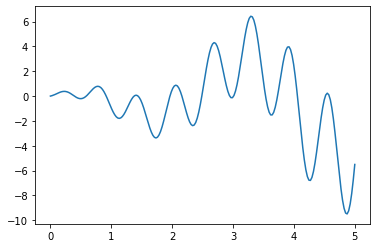

In [151]:
# define FEA parameters as Genetric Algorithm genes
"""
Height: 25-100 um
Diameter: 25-100 um
Elastic Modulus: 0.1-5 MPa
"""

# GA required libraries
from operator import ge
import numpy as np
import matplotlib.pyplot as plt


# define GA hyper parameters
DNA_SIZE = 10               # DNA length
POP_SIZE = 100              # population size
CROSS_RATE = 0.8            # mating probability (DNA crossover)
MUTATION_RATE = 0.003       # mutation probability
N_GENERATIONS = 200         # number of generations
X_BOUND = [0, 5]            # x upper and lower bounds

# the model\environment function
"""
In our case, change it to overall simulation
input: all fiber design parameter
output: the Fad
"""
def F(x): 
    return np.sin(10*x)*x + np.cos(2*x)*x     # to find the maximum of this function


# the fitness function, adding an arbitary small number to ensure non-zero
"""
input: list of predicted outcome
output: list of fitness for each outcome
"""
def get_fitness(pred): 
    return pred + 1e-3 - np.min(pred)


def translateDNA(pop): # this is to translate the gene into a linear scale of input 
    """
    input: binary 2D array of genes of entire pop
    output: linear 1D array of pop size, each containing the linear scaled DNA of each sample, and
    also normalize it to the desire input range, like the last layer of NN
    """
    
    return pop.dot(2 ** np.arange(DNA_SIZE)[::-1]) / float(2**DNA_SIZE-1) * X_BOUND[1] # convert binary DNA to decimal and normalize it to a range(0, 5)

def select(pop, fitness):    # nature selection wrt pop's fitness
    """
    input:  pop 2D array of POP_SIZE x DNA_SIZE
            fitness is 1D array of POP_SIZE, containing the fitness score of each sample
    output: return the selected population as a 1D array, there might be duplicated samples selected
    """
    
    idx = np.random.choice(np.arange(POP_SIZE), size=POP_SIZE, replace=True,     
                           p=fitness/fitness.sum())
    # generate a list index of the size of population, of random numbers from the population index, allow multiple selection of the same sample, using the fitness score
    # as a probability to guide the selection
    return pop[idx]

def crossover(parent, pop):     # mating process (genes crossover)
    """
    input:  parent is 1D array of size DNA_SIZE
            pop is 2D array of size POP_SIZE * DNA_SIZE
    action: randomly select one sample from pop, randomly generate a mask indexing the genes in the DNA to be passed from the sample to parent
    output: parent with some genes passed from the sample
    """
    if np.random.rand() < CROSS_RATE:
        i_ = np.random.randint(0, POP_SIZE, size=1)                             # select a sample from pop
        cross_points = np.random.randint(0, 2, size=DNA_SIZE).astype(bool)      # generate crossover points = a 1D array of boolean with size of DNA_size used as mask
        parent[cross_points] = pop[i_, cross_points]                            # mating and produce one child
        # numpy array allows the indexing using boolean array for masking operation, the indexing array has to be of the same size as the main array
        
    return parent

def mutate(child):
    """
    input:  child is 1D array of size DNA_SIZE
    action: determine based on mutation_rate on each gene of child to be swopped
    output: child with mutated gene
    """
    for point in range(DNA_SIZE):                                               # for every gene in the child
        if np.random.rand() < MUTATION_RATE:                                    # if throw a float dice between 0-1 and its value falls below mutation rate
            child[point] = 1 if child[point] == 0 else 0                        # flip the gene between 0 and 1
    return child

pop = np.random.randint(10, size=(POP_SIZE, DNA_SIZE))   # initialize the pop DNA with int < 2, i.e. 0 or 1, for the size of Pop rows, DNA columns

plt.ion()                       # something about plotting
x = np.linspace(*X_BOUND, 200)  # return a 1d array with evenly spaced 200 numbers between the X_BOUND
plt.plot(x, F(x))               # plot the model\environment function as a baseline

for _ in range(N_GENERATIONS):
    F_values = F(translateDNA(pop))    # compute outcome values for every sample in the entire population, result is 1d array of POP_SIZE

    # something about plotting
    if 'sca' in globals(): 
        sca.remove()
    sca = plt.scatter(translateDNA(pop), F_values, s=200, lw=0, c='red', alpha=0.5); plt.pause(0.05) # scatter plot of all population and their outcome

    # GA part (evolution)
    fitness = get_fitness(F_values)                         # calc fitness of all outcome values
    print("Most fitted DNA: ", pop[np.argmax(fitness), :])  # printout the DNA of the most fitted sample
    pop = select(pop, fitness)                              # select 1D array of children with same number as parent, based on probability derived from fitness
    pop_copy = pop.copy()
    for parent in pop:                                      # for every sample in the population
        child = crossover(parent, pop_copy)                 # marry it with another random sample in the population and make a child
        child = mutate(child)                               # mutate random genes in the child
        parent[:] = child                                   # the sample in the population is replaced by its child

plt.ioff(); plt.show()